In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import seaborn as sns

from typing import *


sns.set(style="darkgrid")

## Load data
Load Covid-19 cases data provided by the New York Times,
along with population density information.

/Users/personal/Documents/Master of Statistics/2/Modern Data Analytics/Project/G0Z39a/src/nepal/ml/transformers/functions.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, self._name] = log_transformer.transform(X[self._name])


<AxesSubplot:xlabel='fips,date'>

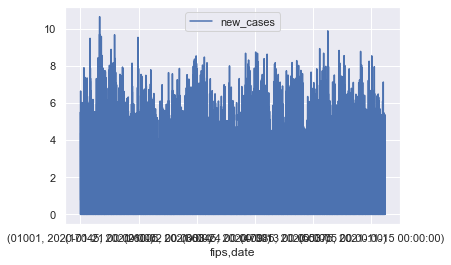

/Users/personal/Documents/Master of Statistics/2/Modern Data Analytics/Project/G0Z39a/src/nepal/ml/transformers/functions.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, self._name] = log_transformer.transform(X[self._name])


<AxesSubplot:xlabel='fips,date'>

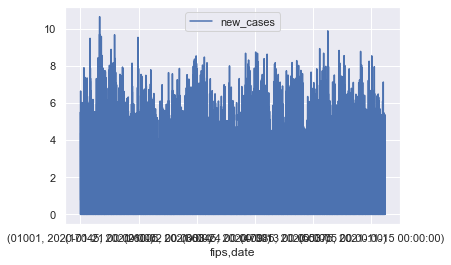

In [3]:
from nepal.datasets import NYTimes, PopulationDensity
from nepal.ml.features.preprocess import Cases, Population
from nepal.ml.transformers import TargetTransform, log_transformer


df: pd.DataFrame = Cases(NYTimes()).preprocessed()
extra_pop: pd.DataFrame = Population(PopulationDensity()).preprocessed()

preprocess = TargetTransform()

df_y: pd.DataFrame = preprocess.transform(df[["new_cases"]])
df_y.plot()

## Experiment setup
We choose a forecasting horizon of 2 weeks (14 days), and setup a sliding window splitter accordingly to use for cross-validation.
The target we will attempt to predict is the amount of new infections per day. To measure performance for this task, we select
MAPE as criterion, given that we want errors to be treated relatively to their actual value.

In [4]:
import lightgbm as lgb

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.loss import mape
from nepal.ml.splitter import Splitter
from nepal.ml.validate import cross_validate
from nepal.ml.forecaster import LGBMForecaster

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)

Here we first determine a performance baseline.

Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

0.30250178015390755


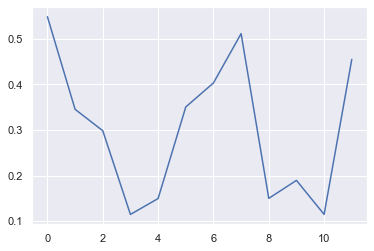

In [4]:
# Create regressor with default parameters
default_lag: Final[int] = 7
forecaster = LGBMForecaster(lgb.LGBMRegressor(objective=mape.name), lag=default_lag)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df_y, loss=mape.function
)

sns.lineplot(data=scores)
print(np.mean(scores))

Now we add additional exogenous information to our forecasting problem.

In [ ]:
# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(objective=mape.name), lag=default_lag)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df_y, Xs=extra_pop, loss=mape.function
)

sns.lineplot(data=scores)
print(np.mean(scores))

We add an approximate for the current number of active infections,
based on the sliding sum of new cases over the past 10 days.

Window size based on [CDC guidelines](https://www.cdc.gov/coronavirus/2019-ncov/hcp/duration-isolation.html).

In [5]:
from sklearn.pipeline import Pipeline
from nepal.ml.transformers import RollingWindowSum, log_transformer

transformers: Pipeline = Pipeline(
    [
        (
            "with_active_infections",
            RollingWindowSum(
                "new_cases", target="infections", window=10, transformer=log_transformer
            ),
        ),
    ]
)

Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

0.3036226081896825


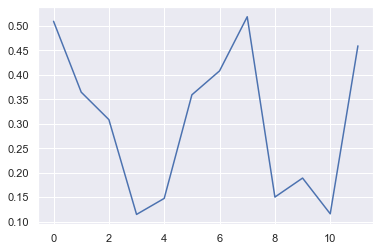

In [7]:
forecaster = LGBMForecaster(
    lgb.LGBMRegressor(objective=mape.name), lag=default_lag, transformers=transformers
)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df_y, Xs=[extra_pop], loss=mape.function
)

sns.lineplot(data=scores)
print(np.mean(scores))

## Window optimization

We use the [optuna](https://optuna.org/) framework to optimize the window size of the endogenous variable.

In [8]:
import optuna


def objective(trial: optuna.Trial) -> float:
    lag: int = trial.suggest_int("lag", 5, 25)
    forecaster = LGBMForecaster(
        lgb.LGBMRegressor(objective=mape.name), lag=lag, transformers=transformers
    )

    scores: Sequence[float] = cross_validate(
        forecaster, splitter=splitter, y=df_y, Xs=[extra_pop], loss=mape.function
    )
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

study.best_params

[I 2022-06-05 18:53:28,119] A new study created in memory with name: no-name-bed6a2a6-e991-49e0-9753-dc84a0b2f099


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 18:54:56,968] Trial 0 finished with value: 0.3036226081896825 and parameters: {'lag': 7}. Best is trial 0 with value: 0.3036226081896825.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 18:56:41,431] Trial 1 finished with value: 0.30997451429534034 and parameters: {'lag': 20}. Best is trial 0 with value: 0.3036226081896825.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 18:58:08,147] Trial 2 finished with value: 0.2995277276464143 and parameters: {'lag': 5}. Best is trial 2 with value: 0.2995277276464143.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 18:59:27,311] Trial 3 finished with value: 0.30975903862187015 and parameters: {'lag': 12}. Best is trial 2 with value: 0.2995277276464143.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 19:00:53,187] Trial 4 finished with value: 0.3109582733611294 and parameters: {'lag': 19}. Best is trial 2 with value: 0.2995277276464143.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 19:02:24,932] Trial 5 finished with value: 0.31093955027384157 and parameters: {'lag': 22}. Best is trial 2 with value: 0.2995277276464143.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 19:04:02,966] Trial 6 finished with value: 0.30995551157337026 and parameters: {'lag': 15}. Best is trial 2 with value: 0.2995277276464143.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
best_lag: Final[int] = 5

## Graph Embedding
We use Neo4J to create an embedding of the US Counties, in order to create features capturing the geographical information.
These features are then used to improve the forecasting accuracy.

We select [FastRP](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/) embeddings, as these are stable and quick to compute ([GraphSage](https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/graph-sage/) is neither).
Optuna is again used to tune the hyperparameters for these embeddings.

In [10]:
from nepal.graph import Connection, LocalConnection

conn: Connection = LocalConnection(
    database="neo4j",
    password="corona",
)

assert conn.is_up()

In [14]:
import optuna

from nepal.graph.gds import CountyEmbedding


embedding = CountyEmbedding()
embedding.create_projection(conn)


def objective(trial: optuna.Trial) -> float:
    forecaster = LGBMForecaster(
        lgb.LGBMRegressor(objective=mape.name), lag=best_lag, transformers=transformers
    )

    neo4j: pd.DataFrame = embedding.load_dataframe(
        connection=conn,
        embedding_dimension=trial.suggest_int("dim", 32, 128, log=True),
        weight2=trial.suggest_float("weight2", 0.0, 1.0),
        weight3=trial.suggest_float("weight3", 0.0, 1.0),
        weight4=trial.suggest_float("weight4", 0.0, 1.0),
        normalization=trial.suggest_float("normalization", -1.0, 1.0),
        property_ratio=0.0,
        self_influence=trial.suggest_float("self_influence", 0.0, 1.0),
    )

    scores: Sequence[float] = cross_validate(
        forecaster,
        splitter=splitter,
        y=df_y,
        Xs=[extra_pop, neo4j],
        loss=mape.function,
    )
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

study.best_params

/Users/personal/Documents/Master of Statistics/2/Modern Data Analytics/Project/G0Z39a/src/nepal/graph/gds/embedding.py:73: UserWarning: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: A graph with name 'counties' already exists.}
  warnings.warn(str(e))
[I 2022-06-05 11:33:00,020] A new study created in memory with name: no-name-b841aad4-b545-42d0-9458-2fb8b2857acb


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:35:00,762] Trial 0 finished with value: 0.35863587033671357 and parameters: {'dim': 72, 'weight2': 0.37854077978036405, 'weight3': 0.6149673172116273, 'weight4': 0.35213715163509074, 'normalization': 0.48474286944703504, 'self_influence': 0.8499185105802718}. Best is trial 0 with value: 0.35863587033671357.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:37:32,870] Trial 1 finished with value: 0.3571813829985527 and parameters: {'dim': 121, 'weight2': 0.012347438724336524, 'weight3': 0.4390397187169419, 'weight4': 0.739567652660214, 'normalization': 0.3755959209263564, 'self_influence': 0.3782024145920334}. Best is trial 1 with value: 0.3571813829985527.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:39:42,635] Trial 2 finished with value: 0.35916751408202924 and parameters: {'dim': 79, 'weight2': 0.04078369037634666, 'weight3': 0.6887173610913776, 'weight4': 0.8523168175118271, 'normalization': 0.6113112064583213, 'self_influence': 0.48960251113318876}. Best is trial 1 with value: 0.3571813829985527.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:41:34,352] Trial 3 finished with value: 0.35910617324669364 and parameters: {'dim': 37, 'weight2': 0.03538202868204199, 'weight3': 0.15706013702754085, 'weight4': 0.8623395043722905, 'normalization': 0.8663177747765893, 'self_influence': 0.43387710164671134}. Best is trial 1 with value: 0.3571813829985527.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:43:28,417] Trial 4 finished with value: 0.35848674892767113 and parameters: {'dim': 71, 'weight2': 0.3697821051610687, 'weight3': 0.2933647180372849, 'weight4': 0.5478778650965741, 'normalization': -0.21682436722431686, 'self_influence': 0.44257903118937914}. Best is trial 1 with value: 0.3571813829985527.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:45:37,551] Trial 5 finished with value: 0.35768151416546234 and parameters: {'dim': 74, 'weight2': 0.9163137284123962, 'weight3': 0.9838137856832769, 'weight4': 0.21720003593981208, 'normalization': -0.5546304353354907, 'self_influence': 0.12028724581394545}. Best is trial 1 with value: 0.3571813829985527.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:48:01,411] Trial 6 finished with value: 0.3582786830936826 and parameters: {'dim': 104, 'weight2': 0.4693258675433807, 'weight3': 0.3029056746615927, 'weight4': 0.06850501975417211, 'normalization': -0.6443414243637424, 'self_influence': 0.036837607428978236}. Best is trial 1 with value: 0.3571813829985527.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:50:15,233] Trial 7 finished with value: 0.3599388214576113 and parameters: {'dim': 99, 'weight2': 0.5829566271843791, 'weight3': 0.9682483625731488, 'weight4': 0.6077408383605367, 'normalization': -0.11957947468401509, 'self_influence': 0.8623224894261488}. Best is trial 1 with value: 0.3571813829985527.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:52:38,178] Trial 8 finished with value: 0.3577443399347646 and parameters: {'dim': 118, 'weight2': 0.31238218200789436, 'weight3': 0.9196270731216363, 'weight4': 0.9729982368072359, 'normalization': 0.29098863917338114, 'self_influence': 0.8455626421868375}. Best is trial 1 with value: 0.3571813829985527.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:54:20,813] Trial 9 finished with value: 0.35749963612382324 and parameters: {'dim': 46, 'weight2': 0.6753109974131081, 'weight3': 0.47578825483541876, 'weight4': 0.6968693918497392, 'normalization': -0.7773426362883518, 'self_influence': 0.36844945246420846}. Best is trial 1 with value: 0.3571813829985527.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:56:22,458] Trial 10 finished with value: 0.3574467911260489 and parameters: {'dim': 52, 'weight2': 0.20483336598393836, 'weight3': 0.012796383462919114, 'weight4': 0.749851259267584, 'normalization': 0.15981060382438514, 'self_influence': 0.226097440516831}. Best is trial 1 with value: 0.3571813829985527.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 11:58:06,854] Trial 11 finished with value: 0.3567171240653518 and parameters: {'dim': 51, 'weight2': 0.17630450140841697, 'weight3': 0.07173736054162, 'weight4': 0.7328964789388661, 'normalization': 0.18786469851294318, 'self_influence': 0.24679665226579728}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:00:00,352] Trial 12 finished with value: 0.35848203999097733 and parameters: {'dim': 32, 'weight2': 0.13536463531003917, 'weight3': 0.01899550021177849, 'weight4': 0.40020927945288803, 'normalization': 0.9588614113479605, 'self_influence': 0.6429709458885082}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:02:07,765] Trial 13 finished with value: 0.35855992126248104 and parameters: {'dim': 54, 'weight2': 0.20056800516391504, 'weight3': 0.410515027831761, 'weight4': 0.7017319441636798, 'normalization': -0.31728094903802095, 'self_influence': 0.24516946811318077}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:03:45,888] Trial 14 finished with value: 0.35931959558762605 and parameters: {'dim': 41, 'weight2': 0.031248799593392718, 'weight3': 0.7276233574845536, 'weight4': 0.9780609055463301, 'normalization': 0.09437282675408454, 'self_influence': 0.6202116057391291}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:05:52,648] Trial 15 finished with value: 0.3585285568845811 and parameters: {'dim': 58, 'weight2': 0.2004219811815752, 'weight3': 0.17783768196819305, 'weight4': 0.473974987735284, 'normalization': 0.46218126272270016, 'self_influence': 0.2812736559411994}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:08:25,720] Trial 16 finished with value: 0.3586037215402819 and parameters: {'dim': 87, 'weight2': 0.753086549371849, 'weight3': 0.5970341299059859, 'weight4': 0.8100532863415657, 'normalization': 0.6943785112606744, 'self_influence': 0.6226206819593617}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:11:20,522] Trial 17 finished with value: 0.35799794099417853 and parameters: {'dim': 127, 'weight2': 0.28352532049679247, 'weight3': 0.8166709992832855, 'weight4': 0.6179647442183341, 'normalization': 0.250549295806986, 'self_influence': 0.006365749987958524}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:13:20,239] Trial 18 finished with value: 0.3577405037924555 and parameters: {'dim': 61, 'weight2': 0.12158274704577998, 'weight3': 0.15609401698837683, 'weight4': 0.8820727345362058, 'normalization': -0.026196215675707346, 'self_influence': 0.15795373681219294}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:15:01,225] Trial 19 finished with value: 0.35908313788623625 and parameters: {'dim': 46, 'weight2': 0.48935303286758186, 'weight3': 0.36276102007387995, 'weight4': 0.6389644469816486, 'normalization': -0.3700034950730926, 'self_influence': 0.9987098520003739}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:17:12,361] Trial 20 finished with value: 0.36035435402184857 and parameters: {'dim': 92, 'weight2': 0.12300677795275536, 'weight3': 0.5334072384777897, 'weight4': 0.4869311908818208, 'normalization': 0.3391136370769514, 'self_influence': 0.29685349896837754}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:19:14,822] Trial 21 finished with value: 0.35802408773568306 and parameters: {'dim': 50, 'weight2': 0.22341482853645261, 'weight3': 0.0044654006565860455, 'weight4': 0.7524939395670177, 'normalization': 0.115696371038906, 'self_influence': 0.15580008777086013}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:21:23,715] Trial 22 finished with value: 0.35954444540363334 and parameters: {'dim': 64, 'weight2': 0.0032859414098618967, 'weight3': 0.09459527900080462, 'weight4': 0.7484088429674414, 'normalization': 0.13293028985311953, 'self_influence': 0.3509843577636208}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:23:26,026] Trial 23 finished with value: 0.3582306274057924 and parameters: {'dim': 52, 'weight2': 0.12371513077560961, 'weight3': 0.23407414264988183, 'weight4': 0.7919832513934686, 'normalization': -0.9785166411813342, 'self_influence': 0.20618722427980385}. Best is trial 11 with value: 0.3567171240653518.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-05 12:25:21,275] Trial 24 finished with value: 0.357662920054915 and parameters: {'dim': 41, 'weight2': 0.2720189877873951, 'weight3': 0.0923794260057057, 'weight4': 0.9056316166776278, 'normalization': 0.653158821216238, 'self_influence': 0.3744276185103007}. Best is trial 11 with value: 0.3567171240653518.


{'dim': 51,
 'weight2': 0.17630450140841697,
 'weight3': 0.07173736054162,
 'weight4': 0.7328964789388661,
 'normalization': 0.18786469851294318,
 'self_influence': 0.24679665226579728}

In [11]:
best_embedding: Final[dict] = {
    "embedding_dimension": 51,
    "weight2": 0.17630450140841697,
    "weight3": 0.07173736054162,
    "weight4": 0.7328964789388661,
    "normalization": 0.18786469851294318,
    "property_ratio": 0.0,
    "self_influence": 0.24679665226579728,
}

In [13]:
from nepal.graph.gds import CountyEmbedding
from nepal.ml.features.embedding import PersistableEmbedding

neo4j: pd.DataFrame = CountyEmbedding().load_dataframe(
    connection=conn,
    **best_embedding,
)

# Store embedding
storage = PersistableEmbedding("counties")
storage.store(neo4j)
embedding = storage.load()

forecaster = LGBMForecaster(
    lgb.LGBMRegressor(objective=mape.name), lag=best_lag, transformers=transformers
)

# Verify that loaded embedding works as intended
scores: Sequence[float] = cross_validate(
    forecaster,
    splitter=splitter,
    y=df_y,
    Xs=[extra_pop, embedding],
    loss=mape.function,
)

print(np.mean(scores))

Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

0.29910118198532915


In [7]:
from nepal.datasets import GovernmentResponse, Vaccinations
from nepal.ml.features.preprocess import GovernmentMeasures

measures = GovernmentMeasures(response=GovernmentResponse(), vaccinations=Vaccinations())
extra_measures: pd.DataFrame = measures.preprocessed()
extra_measures

StringencyIndex  GovernmentResponseIndex  \
fips  date                                                   
01001 2020-12-13            43.52                    47.40   
      2020-12-14            43.52                    47.40   
      2020-12-15            43.52                    48.65   
      2020-12-16            43.52                    48.65   
      2020-12-17            43.52                    48.65   
...                           ...                      ...   
UNK   2022-05-21              NaN                      NaN   
      2022-05-21              NaN                      NaN   
      2022-05-21              NaN                      NaN   
      2022-05-21              NaN                      NaN   
      2022-05-21              NaN                      NaN   

                  ContainmentHealthIndex  EconomicSupportIndex  \
fips  date                                                       
01001 2020-12-13                   48.81                  37.5   
      2020-12-14                   48.81                  37.5   
      2020-12-15                   50.24                  37.5   
      2020-12-16                   50.24                  37.5   
      2020-12-17                   50.24                  37.5   
...                                  ...                   ...   
UNK   2022-05-21                     NaN                   NaN   
      2022-05-21                     NaN                   NaN   
      2022-05-21                     NaN                   NaN   
      2022-05-21                     NaN                   NaN   
      2022-05-21                     NaN                   NaN   

                  Completeness_pct  Administered_Dose1_Pop_Pct  \
fips  date                                                       
01001 2020-12-13               0.0                         0.0   
      2020-12-14               0.0                         0.0   
      2020-12-15               0.0                         0.0   
      2020-12-16               0.0                         0.0   
      2020-12-17               0.0                         0.0   
...                            ...                         ...   
UNK   2022-05-21              73.5                         NaN   
      2022-05-21              96.0                         NaN   
      2022-05-21              96.8                         NaN   
      2022-05-21              97.2                         NaN   
      2022-05-21              97.1                         NaN   

                  Administered_Dose1_Recip_18PlusPop_Pct  \
fips  date                                                 
01001 2020-12-13                                     0.0   
      2020-12-14                                     0.0   
      2020-12-15                                     0.0   
      2020-12-16                                     0.0   
      2020-12-17                                     0.0   
...                                                  ...   
UNK   2022-05-21                                     NaN   
      2022-05-21                                     NaN   
      2022-05-21                                     NaN   
      2022-05-21                                     NaN   
      2022-05-21                                     NaN   

                  Administered_Dose1_Recip_65PlusPop_Pct  \
fips  date                                                 
01001 2020-12-13                                     0.0   
      2020-12-14                                     0.0   
      2020-12-15                                     0.0   
      2020-12-16                                     0.0   
      2020-12-17                                     0.0   
...                                                  ...   
UNK   2022-05-21                                     NaN   
      2022-05-21                                     NaN   
      2022-05-21                                     NaN   
      2022-05-21                                    

Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

0.35906371185888974


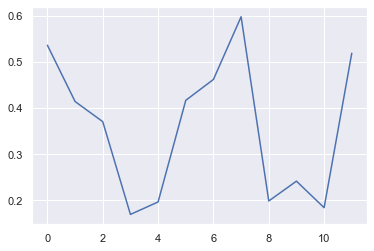

In [8]:
from nepal.ml.features.embedding import PersistableEmbedding


# Load embedding
embedding = PersistableEmbedding("counties").load()

forecaster = LGBMForecaster(
    lgb.LGBMRegressor(objective=mape.name), lag=best_lag, transformers=transformers
)

# Pre-join measures, population data and embedding data
Xs = (
    df_y.join(extra_measures)
    .join(extra_pop)
    .join(embedding)
    .drop(columns=df_y.columns)
    .groupby(level="fips")
    .apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
)

# Compute new score
scores: Sequence[float] = cross_validate(
    forecaster,
    splitter=splitter,
    y=df_y,
    Xs=[Xs],
    loss=mape.function,
)

sns.lineplot(data=scores)
print(np.mean(scores))

In [ ]:
import optuna


def objective(trial: optuna.Trial) -> float:
    forecaster = LGBMForecaster(
        lgb.LGBMRegressor(objective=mape.name), lag=best_lag, transformers=transformers
    )

    lag: int = trial.suggest_int("lag", 10, 20, 1)
    lagged_measures = extra_measures.groupby(level="fips").shift(lag)
    Xs = (
        df_y.join(lagged_measures)
        .join(extra_pop)
        .join(embedding)
        .drop(columns=df_y.columns)
        .groupby(level="fips")
        .apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))
    )

    scores: Sequence[float] = cross_validate(
        forecaster,
        splitter=splitter,
        y=df_y,
        Xs=[Xs],
        loss=mape.function,
    )
    return np.mean(scores)


search_space = {"lag": list(range(10, 21))}
study = optuna.create_study(
    direction="minimize", sampler=optuna.samplers.GridSampler(search_space)
)
study.optimize(objective, n_trials=10)

study.best_params

[I 2022-06-06 09:55:58,664] A new study created in memory with name: no-name-94dbf950-1c4b-48e0-8862-bc8843bad090


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-06 10:00:20,595] Trial 0 finished with value: 0.3591837620642498 and parameters: {'lag': 20}. Best is trial 0 with value: 0.3591837620642498.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-06 10:05:00,238] Trial 1 finished with value: 0.35888833391030794 and parameters: {'lag': 19}. Best is trial 1 with value: 0.35888833391030794.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-06 10:11:11,148] Trial 2 finished with value: 0.3588525031737469 and parameters: {'lag': 13}. Best is trial 2 with value: 0.3588525031737469.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-06 10:16:57,566] Trial 3 finished with value: 0.3594997554419315 and parameters: {'lag': 10}. Best is trial 2 with value: 0.3588525031737469.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-06 10:22:34,213] Trial 4 finished with value: 0.358580952690543 and parameters: {'lag': 12}. Best is trial 4 with value: 0.358580952690543.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-06 10:27:22,149] Trial 5 finished with value: 0.35967347997842364 and parameters: {'lag': 11}. Best is trial 4 with value: 0.358580952690543.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-06 10:31:43,587] Trial 6 finished with value: 0.35909803632156184 and parameters: {'lag': 17}. Best is trial 4 with value: 0.358580952690543.


Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-06 10:37:34,191] Trial 7 finished with value: 0.3609366723534295 and parameters: {'lag': 15}. Best is trial 4 with value: 0.358580952690543.


In [ ]:
measures_lag: Final[int] = 12